# ML-CV-EmotionDetector

Aufgabe im Rahmen des KI-Labors der [HKA](https://www.h-ka.de/).

Gruppe der Overfitter:
- [Tr33Bug](https://github.com/Tr33Bug)
- [gusse-dev](https://github.com/Gusse-dev)
- [CronJorian](https://github.com/CronJorian)
- [BFuertsch](https://github.com/BenJosh95)

--- 
## Vorgehen




1. Recherche: 
    - Framework: Tensorflow/Keras
    - Welches Modell? --> EfficientNet 
        - in Keras/TF vorhanden (`tf.keras.applications.EfficientNetB0`)
        - Rechenauffwand ist verhältnissmäßig gering --> Mehr Finetunig möglich!
    - Welcher Datensatz? 
        - AffectNetHQ: 
            - 8 Emotionen ("ANGER", "CONTEMPT", "DISGUST", "FEAR", "HAPPY", "NEUTRAL", "SAD", "SUPRISE")
            - ca. 31000 Bilder
            - Farbbilder, verschiedene Bildauflösungen und Formate
            - *Nicht einwandfrei gelabled!*
            - https://www.kaggle.com/datasets/tom99763/affectnethq
        - FER13
            - 7 Emotionen ("Angry", "disgust", "fear", "happy", "neutral", "sad", "surprise")
            - ca. 35000 Bilder
            - Schwarzweiß-Bilder, 48x48pixel Auflösung
            - *Nicht einwandfrei gelabled!* minimal besser als AffectNet
            - https://www.kaggle.com/datasets/msambare/fer2013
        - Weitere Datensätze nicht erreichbar oder schlechter geeignet!
    - Rechenkapazität
        - Google Colab Free mit Google Drive anbindung
        - Michis GTX 1070, Henriks RTX 3070
2. Arbeitsschritte:
    1. Data-Engineering, EDA
    2. Modellauswahl + Modellvorbereitung
    3. BaseLine-Model(CNN) konzipieren
    4. Hyperparameter testen
    5. Modelle trainieren
    6. Metriken und Modelle extrahieren
    7. Demo/Showcase konzipieren
    8. Dokumentation und Präsentation

## Imports

In [ ]:
## Imports 
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization, Activation, RandomBrightness, RandomContrast, RandomFlip, RandomCrop, Resizing, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
## =========================== Function Definitions =========================== ##

## image count function definition
def imgCount(dir):
    jpgCount = 0
    pngCount = 0

    for path,_,files in os.walk(dir):
        
        for file in files:
            _,ext = os.path.splitext(file)
            if ext == ".jpg":
                jpgCount += 1
            else:
                pngCount += 1
    return (jpgCount, pngCount)


## =========================== Define Lables =========================== ##
#CLASSES = ["ANGER", "CONTEMPT", "DISGUST", "FEAR", "HAPPY", "NEUTRAL", "SAD", "SUPRISE"]
# CLASSES = ["ANGER", "DISGUST", "FEAR", "HAPPY", "NEUTRAL", "SAD", "SUPRISE"]
CLASSES = ["ANGER", "HAPPY", "NEUTRAL", "SAD"]
NUM_CLASSES = len(CLASSES)

## =========================== Image and Dataset Variables =========================== ##
## constants def
IMG_WIDTH = 224
IMG_HEIGHT = 224

BATCH_SIZE = 32
SPLIT = (80,20)

## =========================== TF-Test GPU and Version =========================== ##
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
## Mount GDrive in GColab
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

---
## Data-Engenieering

--- 
### Datenvorverarbeitung I - Ordnerstruktur Herstellen und Image Resize

In [ ]:
## =========================== Initial Folder-Paths =========================== ##
## dataset directory
root_directory = "/content/drive/MyDrive/KaggleAPI/Datasets/affectnethq/"
root_directory = "./Datasets/"

## affectnet dataset
directory = root_directory + "affectnet_split/"
## fer13 Dataset
# directory = root_directory + "fer13_split/"
train_directory = directory + "train"
test_directory = directory + "test"

## model directory
model_folder = root_directory + "models/"

In [ ]:
df = pd.read_csv(root_directory + "labels.csv")
df = df.rename(columns={'pth': 'image_path', 'label': 'label'})
df["image_shape"] = None

# Create image size entries in the dataframe
for idx, rows in df.iterrows():
    image_path = root_directory + "/" + rows.image_path
    image = Image.open(image_path)
    df.loc[idx, "image_shape"] = image.size

In [ ]:
print(df["image_shape"].min())
print(df["image_shape"].max())

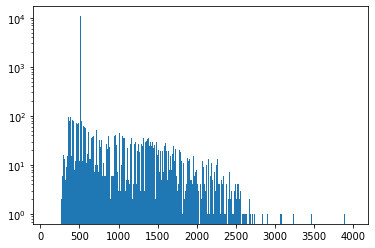

In [ ]:
x = []
y = []

for item in df["image_shape"].iteritems():
    x.append(item[1][0])
    y.append(item[1][1])

# Plot the distribution of the image sizes
bins = np.arange(100,4000,2)
plt.hist(x,bins=bins, log=True)
plt.show()

In [ ]:
# Create directory on same level
new_dir = root_directory + "affectnet_resized"
new_width = 224
new_height = 224

if not os.path.exists(new_dir):
    os.mkdir(new_dir)

for _,dirs,_ in os.walk(root_directory):
    for directory in dirs:
        # Create new directory
        dir_path = new_dir + "/" + directory
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
            
        # Iterate over images, resize the to 224x224 and save them, keep the name
        for root,_,files in os.walk(root_directory + "/" + directory):
            
            new_image_directory_path = new_dir + "/" + directory
        
            for file in files:
                image_path = root + "/" + file
                if os.path.isfile(image_path):
                    image = Image.open(image_path)
                    image = image.resize((new_width, new_height))
                    image.save(new_image_directory_path + "/" + file)

--- 
### Datenvorverarbeitung II - JPG to PNG Conversion


In [ ]:
## TEST image conversion

imgPath = "/content/drive/MyDrive/KaggleAPI/Datasets/affectnethq_resized_manual/affecnet_resized_order/happy/"
# read the image in 
photoJPG = plt.imread(imgPath + "image0041721.jpg")
photoPNG = plt.imread(imgPath + "ffhq_4054.png")

# Print image values
print(photoPNG.min(), "bis", photoPNG.max())
print(photoJPG.min(), "bis", photoJPG.max())

img = Image.open(imgPath + "image0041721.jpg")
img.save(imgPath + "image0041721.png")

photoNewPNG = plt.imread(imgPath +"image0041721.png")
print(photoNewPNG.min(),photoNewPNG.max() )
plt.imshow(photoNewPNG)

In [ ]:
print("Number of JPG:",imgCount(directory)[0], "\nNumber of PNG:", imgCount(directory)[1])

In [ ]:
# Convert every JPG to PNG
for path,_,files in os.walk(directory):
    
    for file in files:
        _,ext = os.path.splitext(file)
        if ext == ".jpg":
            image_path = path + "/" + file
            filename = file[:-3]
            image = Image.open(image_path)  
            image.save(path + '/' + filename + "png")
            os.remove(image_path)

**Ergebnis: Ein directory "affectnet_resized" mit 8 subdirectories für die 8 Klassen. Alle Bilder das .png-Format**

--- 
### Datenvorverarbeitung III - Split dataset into train and test directories

In [ ]:
import random

current_directory = "affecnet_resized_order"
new_directory = "affectnet_split"
train_directory = new_directory + "/" + "train"
test_directory = new_directory + "/" + "test"


if not os.path.exists(new_directory):
    os.mkdir(new_directory)
if not os.path.exists(train_directory):
    os.mkdir(train_directory)
if not os.path.exists(test_directory):
    os.mkdir(test_directory)

for _,sub_directories,_ in os.walk(current_directory):
    for sub_dir in sub_directories:
        
        # Create subdirectories
        train_subdir = train_directory + "/" + sub_dir
        test_subdir = test_directory + "/" + sub_dir
        if not os.path.exists(train_subdir):
            os.mkdir(train_subdir)
        if not os.path.exists(test_subdir):
            os.mkdir(test_subdir)
            
        # Iterate over images
        original_directory = current_directory + "/" + sub_dir 
        for _,_,files in os.walk(original_directory):
            
            size = len(files)
            cut = int(0.8 * size)
            random.seed(0)
            random.shuffle(files)
            train_list = files[:cut]
            test_list = files[cut:]
            
            for file in train_list:
                original_image_path = original_directory + "/" + file 
                if os.path.isfile(original_image_path):
                    new_image_path = train_subdir + "/" + file
                    image = Image.open(original_image_path)
                    image.save(new_image_path)
                
                
            for file in test_list:
                original_image_path = original_directory + "/" + file 
                if os.path.isfile(original_image_path):
                    new_image_path = test_subdir + "/" + file
                    image = Image.open(original_image_path)
                    image.save(new_image_path)

***Ergebnis: Ein directory "affectnet_split" mit zwei Subdirectories train (80%) und test (20%), Daten jeweils aus den 8 Klassen, subdirectories für jede Klasse***

--- 
## ML-Data-Prep. - dataset and batch generation

**Daten Annahme:**
 - Test und Train Datensatz in verschiedenen Ordnern
 - Jede Klasse hat eigenen Ordner mit den entsprechenden Bildern
 - 4 Klassen ("ANGER", "HAPPY", "NEUTRAL", "SAD")
 - Alle Bilder gleiche Größe und gleiches Format 

### GDrive Mounten


In [ ]:
## Mount GDrive in GColab
from google.colab import drive
drive.mount('/content/drive')

### Load Dataset Directorys

In [ ]:
## Dataset directory
# root_directory = "./Datasets/"

## Google Drive Root-Dir
root_directory = "/content/drive/MyDrive/KaggleAPI/Datasets/"


## affectnet dir
directory = root_directory + "affectnet_split/"
## fer13 dir
# directory = root_directory + "fer13_split/"

train_directory = directory + "train"
test_directory = directory + "test"

## Model directory
model_folder = root_directory + "models/"

### Datenverteilung

In [ ]:
## Count all files in the train dataset folder
train_distibution = []
for _,dirs,_ in os.walk(train_directory):
  for x in dirs:
    train_distibution.append(len(os.listdir(train_directory + "/" + x)))

In [ ]:
## Print number of Files in train-dataset
print(train_distibution)

[3319, 3464, 2468, 2675]


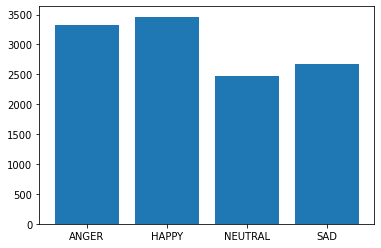

In [ ]:
## Plot train-dataset distribution
plt.bar(CLASSES, train_distibution)
plt.show()

In [ ]:
## Check for file-format (PNG or JPG)
print("Number of JPG:",imgCount(directory)[0], "\nNumber of PNG:", imgCount(directory)[1])

Number of JPG: 0 
Number of PNG: 14909


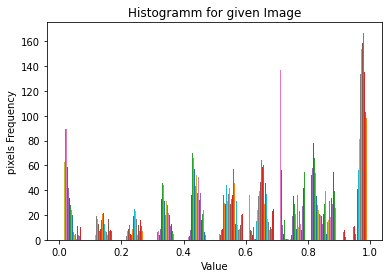

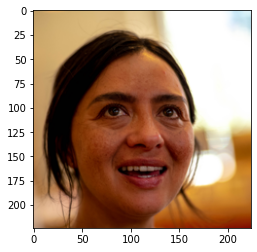

In [ ]:
## Display the value distribution of one test image

## Load image
imgPath = train_directory + "/happy/ffhq_10.png"


plt.xlabel("Value")
# y co-ordinate denotation.
plt.ylabel("pixels Frequency")
plt.title("Histogramm for given Image")
plt.xlabel("Value")
plt.ylabel("pixels Frequency")
img=mpimg.imread(imgPath)
x=img[:,:,0]
plt.hist(x)
plt.show()

plt.imshow(img)
plt.show()

### Load Datasets

In [ ]:
# Load datasets from directory - lables from folder
train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory, image_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                            seed=0, shuffle=True, batch_size=BATCH_SIZE, label_mode="categorical", 
                                                            subset="training", validation_split=0.2)

valid_dataset = tf.keras.utils.image_dataset_from_directory(train_directory, image_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                            seed=0, shuffle=True, batch_size=BATCH_SIZE, label_mode="categorical", 
                                                            subset="validation", validation_split=0.2)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory, image_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                            seed=0, shuffle=True, batch_size=BATCH_SIZE, label_mode="categorical")

print(type(train_dataset))

Found 11926 files belonging to 4 classes.
Using 9541 files for training.
Found 11926 files belonging to 4 classes.
Using 2385 files for validation.
Found 2983 files belonging to 4 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [ ]:
## Print one batch of the train-dataset
print(next(iter(train_dataset))) 

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[ 27.,  13.,  12.],
         [ 27.,  13.,  12.],
         [ 28.,  14.,  13.],
         ...,
         [ 36.,  15.,  10.],
         [ 39.,  15.,  13.],
         [ 40.,  16.,  14.]],

        [[ 27.,  13.,  12.],
         [ 27.,  13.,  12.],
         [ 28.,  14.,  13.],
         ...,
         [ 36.,  15.,  10.],
         [ 37.,  16.,  13.],
         [ 38.,  17.,  14.]],

        [[ 27.,  13.,  12.],
         [ 27.,  13.,  12.],
         [ 28.,  14.,  13.],
         ...,
         [ 36.,  17.,  11.],
         [ 38.,  19.,  13.],
         [ 38.,  19.,  13.]],

        ...,

        [[208., 204., 205.],
         [225., 221., 222.],
         [240., 238., 241.],
         ...,
         [190., 188., 189.],
         [192., 190., 191.],
         [197., 195., 196.]],

        [[225., 223., 226.],
         [232., 230., 233.],
         [244., 242., 247.],
         ...,
         [190., 188., 189.],
         [190., 188., 189.],
       

### Normalisierung und One-Hot Encoding

**Normalisierung:**
    - "EfficientNet models expect their inputs to be float tensors of pixels with values in the [0-255] range." Zitat: https://keras.io/api/applications/efficientnet/#efficientnetb0-function


**One-Hot-Encoding:**
    - Die Funktion `tf.keras.utils.image_dataset_from_directory` macht das mit `label_mode="categorical"` selbstständig.

### Data Augmentation

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

## Define augmentation-functions
# BUG: https://github.com/keras-team/keras-cv/issues/581
augmentation = Sequential([
  RandomBrightness(0.15),
  RandomContrast(0.15), 
  RandomFlip("horizontal"),
  RandomCrop(200, 200),
  Resizing(IMG_HEIGHT, IMG_WIDTH)
])

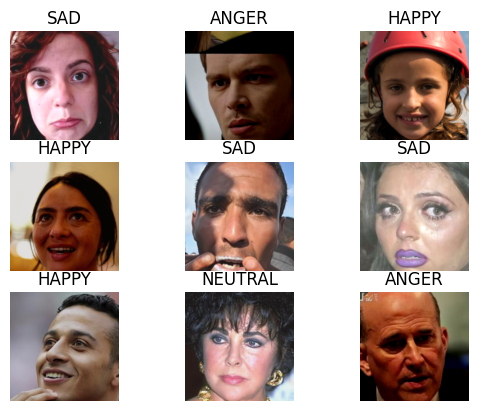

In [ ]:
# Data augmentation option 1: modify the datasets
train_dataset_augmented_concat = train_dataset.concatenate(train_dataset.map(lambda image, label: (augmentation(image, training=True), label), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE))
train_dataset_augmented = train_dataset.map(lambda image, label: (augmentation(image, training=True), label), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

## Print 9 sample images from the augmented dataset
for images, labels in train_dataset_augmented.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    ax.axis("off")
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[np.argmax(labels[i])])

## BaseLine-Model

In [ ]:
BASELINE_TRAIN_EPOCHS = 20
BASELINE_PATIENCE = 5

### BaseLine-Model Definition

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
## BaseLine Model
baseLine_model = Sequential()

baseLine_model.add(Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3)))
baseLine_model.add(Activation('relu'))
baseLine_model.add(BatchNormalization())

baseLine_model.add(Conv2D(32, (3,3)))
baseLine_model.add(Activation('relu'))
baseLine_model.add(BatchNormalization())

baseLine_model.add(MaxPooling2D(pool_size=(2, 2)))

baseLine_model.add(Conv2D(16, (3,3)))
baseLine_model.add(Activation('relu'))
baseLine_model.add(BatchNormalization())

baseLine_model.add(Conv2D(8, (3,3)))
baseLine_model.add(Activation('relu'))
baseLine_model.add(BatchNormalization())

baseLine_model.add(MaxPooling2D(pool_size=(2, 2)))
baseLine_model.add(BatchNormalization())

baseLine_model.add(Flatten())
baseLine_model.add(Dropout(rate=0.5))
baseLine_model.add(Dense(512)) 
baseLine_model.add(Activation('relu'))
baseLine_model.add(Dropout(rate=0.5))
baseLine_model.add(Dense(256))
baseLine_model.add(Activation('relu'))
baseLine_model.add(Dropout(rate=0.5))
baseLine_model.add(Dense(256))
baseLine_model.add(Activation('relu'))


baseLine_model.add(Dense(NUM_CLASSES))

In [ ]:
# defining metrics for training
BASELINE_METRICS = [tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')]

# defining callbacks for early stopping
BASELINE_EARLY_STOPPING = EarlyStopping(verbose=1, patience=BASELINE_PATIENCE, restore_best_weights=True)

In [ ]:
# compile the model 
baseLine_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=BASELINE_METRICS)

# print summary of the model
print(baseLine_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      18464     
                                                                 
 activation_1 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                        

### BaseLine-Model Training

In [ ]:
# train model
baseLine_train_history = baseLine_model.fit(train_dataset_augmented_concat, validation_data=valid_dataset, epochs=BASELINE_TRAIN_EPOCHS, verbose=1, callbacks=[BASELINE_EARLY_STOPPING])

Epoch 1/20
598/598 [==============================] - 88s 145ms/step - loss: 2.6505 - categorical_accuracy: 0.2831 - val_loss: 1.3360 - val_categorical_accuracy: 0.3753
Epoch 2/20
598/598 [==============================] - 81s 135ms/step - loss: 1.3620 - categorical_accuracy: 0.3572 - val_loss: 1.2869 - val_categorical_accuracy: 0.4428
Epoch 3/20
598/598 [==============================] - 80s 133ms/step - loss: 1.3200 - categorical_accuracy: 0.4104 - val_loss: 1.2282 - val_categorical_accuracy: 0.4532
Epoch 4/20
598/598 [==============================] - 82s 136ms/step - loss: 1.4000 - categorical_accuracy: 0.4218 - val_loss: 1.6634 - val_categorical_accuracy: 0.4335
Epoch 5/20
598/598 [==============================] - 80s 133ms/step - loss: 2.0140 - categorical_accuracy: 0.3613 - val_loss: 1.5871 - val_categorical_accuracy: 0.2994
Epoch 6/20
598/598 [==============================] - 82s 137ms/step - loss: 1.8431 - categorical_accuracy: 0.2717 - val_loss: 1.5445 - val_categorical_acc

**Results (1. Epoche):**
Results of various test for hyperparameters and architecture!
```
Used: train_dataset_augmented

  Changes to: Learning_Rate
  Architecture: conv 64,32 + Dense 128,64,32

      - learning_rate= 0.01
      Epoch 1/10 299/299 [==============================] - 71s 133ms/step - loss: 1.6015 - categorical_accuracy: 0.2552 - val_loss: 1.3412 - val_categorical_accuracy: 0.2475 

      - learning_rate= 0.001
      Epoch 1/10 299/299 [==============================] - 101s 273ms/step - loss: 2.0015 - categorical_accuracy: 0.2352 - val_loss: 2.1132 - val_categorical_accuracy: 0.2175 

      - learning_rate= 0.0001
      Epoch 1/10 299/299 [==============================] - 75s 188ms/step - loss: 1.4115 - categorical_accuracy: 0.2800 - val_loss: 1.2998 - val_categorical_accuracy: 0.2533 

  Changes to: Architecture
  learning_rate= 0.0001

      - Arch: conv 64,32,16,8 + Dense 512,128,64,32
      Epoch 1/10 299/299 [==============================] - 122s 217ms/step - loss: 7.7305 - categorical_accuracy: 0.2773 - val_loss: 7.9984 - val_categorical_accuracy: 0.2677 

      - Arch: conv 64,32,16 + Dense 256,256,128
      Epoch 1/10 299/299 [==============================] - 99s 141ms/step - loss: 7.2115 - categorical_accuracy: 0.2881 - val_loss: 7.8462 - val_categorical_accuracy: 0.2948

      - Arch: conv 32,64,128 + Dense 256,256,128
      Epoch 1/10 299/299 [==============================] - 94s 300ms/step - loss: 7.4523 - categorical_accuracy: 0.2549 - val_loss: 7.4745 - val_categorical_accuracy: 0.2717

      - Arch: conv 64,32,16,8 + Dense 256, 128, 64
      Epoch 1/10 299/299 [==============================] - 130s 240ms/step - loss: 3.9697 - categorical_accuracy: 0.2754 - val_loss: 2.8383 - val_categorical_accuracy: 0.3166


FINAL ARCH: 
    train_dataset_augmented_concat
      - Arch: conv 64,32,16,8 + Dense 512, 256, 256
      Epoch 1/10 299/299 [==============================] - 74s 242ms/step - loss: 1.5975 - categorical_accuracy: 0.3753 - val_loss: 1.3568 - val_categorical_accuracy: 0.4658


    Epoch 1/25
    598/598 [==============================] - 105s 166ms/step - loss: 1.7295 - categorical_accuracy: 0.3610 - val_loss: 1.2201 - val_categorical_accuracy: 0.4717
    Epoch 2/25
    598/598 [==============================] - 54s 91ms/step - loss: 1.2756 - categorical_accuracy: 0.4475 - val_loss: 1.1908 - val_categorical_accuracy: 0.4809
    Epoch 3/25
    598/598 [==============================] - 54s 91ms/step - loss: 1.2639 - categorical_accuracy: 0.4591 - val_loss: 1.2412 - val_categorical_accuracy: 0.4839
    Epoch 4/25
    598/598 [==============================] - 54s 91ms/step - loss: 1.2912 - categorical_accuracy: 0.4707 - val_loss: 1.2863 - val_categorical_accuracy: 0.5082
    Epoch 5/25
    598/598 [==============================] - 54s 90ms/step - loss: 2.4386 - categorical_accuracy: 0.4569 - val_loss: 1.1240 - val_categorical_accuracy: 0.4998
    Epoch 6/25
    598/598 [==============================] - 54s 90ms/step - loss: 3.3485 - categorical_accuracy: 0.4697 - val_loss: 5.0774 - val_categorical_accuracy: 0.5036
    Epoch 7/25
    598/598 [==============================] - 54s 90ms/step - loss: 2.6635 - categorical_accuracy: 0.4523 - val_loss: 2.0948 - val_categorical_accuracy: 0.4478
    Epoch 8/25
    598/598 [==============================] - 54s 90ms/step - loss: 2.4465 - categorical_accuracy: 0.4590 - val_loss: 3.3772 - val_categorical_accuracy: 0.4952
    Epoch 9/25
    598/598 [==============================] - 54s 90ms/step - loss: 1.8603 - categorical_accuracy: 0.4304 - val_loss: 2.2337 - val_categorical_accuracy: 0.4621
    Epoch 10/25
    598/598 [==============================] - 54s 90ms/step - loss: 2.0291 - categorical_accuracy: 0.4395 - val_loss: 2.4065 - val_categorical_accuracy: 0.4713
    Epoch 11/25
    598/598 [==============================] - 56s 93ms/step - loss: 2.2854 - categorical_accuracy: 0.4531 - val_loss: 2.3398 - val_categorical_accuracy: 0.4683
    Epoch 12/25
    597/598 [============================>.] - ETA: 0s - loss: 2.3921 - categorical_accuracy: 0.4557Restoring model weights from the end of the best epoch: 5.
    598/598 [==============================] - 55s 92ms/step - loss: 2.3925 - categorical_accuracy: 0.4556 - val_loss: 2.2445 - val_categorical_accuracy: 0.4461
    Epoch 12: early stopping

    --> BASELINE_50_affAHNS_retrain0_lr0001_es7.h5
    
    
    
    train_dataset_augmented
    - Arch: conv 64,32,16,8 + Dense 512, 256, 256
    Epoch 1/15
    299/299 [==============================] - 77s 234ms/step - loss: 2.2446 - categorical_accuracy: 0.2937 - val_loss: 1.3020 - val_categorical_accuracy: 0.4340
    Epoch 2/15
    299/299 [==============================] - 71s 234ms/step - loss: 1.3619 - categorical_accuracy: 0.3619 - val_loss: 1.2785 - val_categorical_accuracy: 0.4419
    Epoch 3/15
    299/299 [==============================] - 69s 229ms/step - loss: 1.3223 - categorical_accuracy: 0.3893 - val_loss: 1.2344 - val_categorical_accuracy: 0.4537
    Epoch 4/15
    299/299 [==============================] - 69s 228ms/step - loss: 1.2990 - categorical_accuracy: 0.4153 - val_loss: 1.2182 - val_categorical_accuracy: 0.4549
    Epoch 5/15
    299/299 [==============================] - 68s 224ms/step - loss: 1.2752 - categorical_accuracy: 0.4365 - val_loss: 1.2376 - val_categorical_accuracy: 0.4553
    Epoch 6/15
    299/299 [==============================] - 69s 227ms/step - loss: 1.2843 - categorical_accuracy: 0.4415 - val_loss: 1.2724 - val_categorical_accuracy: 0.4667
    Epoch 7/15
    299/299 [==============================] - 68s 223ms/step - loss: 1.2688 - categorical_accuracy: 0.4527 - val_loss: 1.2558 - val_categorical_accuracy: 0.4746
    Epoch 8/15
    299/299 [==============================] - 68s 225ms/step - loss: 1.2977 - categorical_accuracy: 0.4609 - val_loss: 1.2013 - val_categorical_accuracy: 0.4813
    Epoch 9/15
    299/299 [==============================] - 68s 225ms/step - loss: 1.3775 - categorical_accuracy: 0.4582 - val_loss: 2.8880 - val_categorical_accuracy: 0.4759
    Epoch 10/15
    299/299 [==============================] - 68s 225ms/step - loss: 2.2842 - categorical_accuracy: 0.4079 - val_loss: 1.7842 - val_categorical_accuracy: 0.3933
    Epoch 11/15
    299/299 [==============================] - 69s 228ms/step - loss: 2.3266 - categorical_accuracy: 0.4212 - val_loss: 4.1684 - val_categorical_accuracy: 0.4834
    Epoch 12/15
    299/299 [==============================] - 68s 225ms/step - loss: 2.9248 - categorical_accuracy: 0.3834 - val_loss: 1.6619 - val_categorical_accuracy: 0.3212
    Epoch 13/15
    298/299 [============================>.] - ETA: 0s - loss: 1.8934 - categorical_accuracy: 0.3175Restoring model weights from the end of the best epoch: 8.
    299/299 [==============================] - 68s 226ms/step - loss: 1.8932 - categorical_accuracy: 0.3175 - val_loss: 1.6054 - val_categorical_accuracy: 0.2956
    Epoch 13: early stopping

    --> BASELINE_47_affAHNS_retrain0_lr0001_es7.h5



    train_dataset_augmented_concat
    - Arch: conv 64,32,16,8 + Dense 512, 256, 256
    Epoch 1/20
    598/598 [==============================] - 88s 145ms/step - loss: 2.6505 - categorical_accuracy: 0.2831 - val_loss: 1.3360 - val_categorical_accuracy: 0.3753
    Epoch 2/20
    598/598 [==============================] - 81s 135ms/step - loss: 1.3620 - categorical_accuracy: 0.3572 - val_loss: 1.2869 - val_categorical_accuracy: 0.4428
    Epoch 3/20
    598/598 [==============================] - 80s 133ms/step - loss: 1.3200 - categorical_accuracy: 0.4104 - val_loss: 1.2282 - val_categorical_accuracy: 0.4532
    Epoch 4/20
    598/598 [==============================] - 82s 136ms/step - loss: 1.4000 - categorical_accuracy: 0.4218 - val_loss: 1.6634 - val_categorical_accuracy: 0.4335
    Epoch 5/20
    598/598 [==============================] - 80s 133ms/step - loss: 2.0140 - categorical_accuracy: 0.3613 - val_loss: 1.5871 - val_categorical_accuracy: 0.2994
    Epoch 6/20
    598/598 [==============================] - 82s 137ms/step - loss: 1.8431 - categorical_accuracy: 0.2717 - val_loss: 1.5445 - val_categorical_accuracy: 0.2734
    Epoch 7/20
    598/598 [==============================] - 80s 133ms/step - loss: 1.7780 - categorical_accuracy: 0.2638 - val_loss: 1.6502 - val_categorical_accuracy: 0.2759
    Epoch 8/20
    597/598 [============================>.] - ETA: 0s - loss: 1.6941 - categorical_accuracy: 0.2561Restoring model weights from the end of the best epoch: 3.
    598/598 [==============================] - 81s 135ms/step - loss: 1.6939 - categorical_accuracy: 0.2560 - val_loss: 1.4767 - val_categorical_accuracy: 0.2168
    Epoch 8: early stopping


    --> BASELINE_44_affAHNS_retrain0_lr0001_es7.h5
```


### BaseLine-Model Evaluation

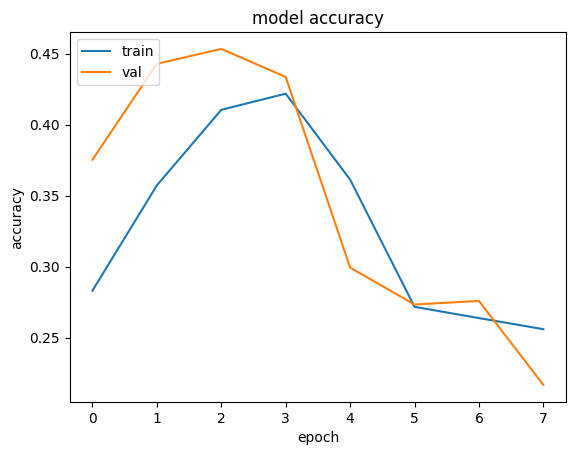

In [ ]:
# Plot the train- and validation-accuracy of last training
plt.plot(baseLine_train_history.history['categorical_accuracy'])
plt.plot(baseLine_train_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

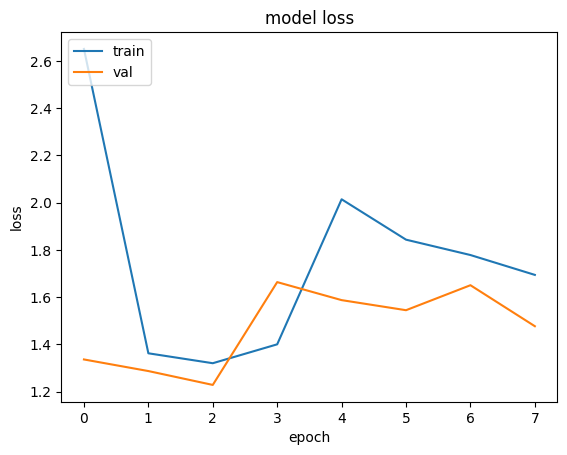

In [ ]:
# Plot the train- and validation-loss of last training
plt.plot(baseLine_train_history.history['loss'])
plt.plot(baseLine_train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# evaluate training with test dataset
loss_test, acc_test = baseLine_model.evaluate(test_dataset, verbose=2)

94/94 - 9s - loss: 1.2339 - categorical_accuracy: 0.4482 - 9s/epoch - 101ms/step


### Save Model

In [ ]:
## save model 
# baseLine_model.save(model_folder + "BASELINE_44_affAHNS_retrain0_lr0001_es7.h5")

In [ ]:
## Load a saved model
baseLine_model = tf.keras.models.load_model(model_folder + "BASELINE_50_affAHNS_retrain0_lr0001_es7.h5")

---
## Transferlearning

---
### Base-Model

In [ ]:
## ML-Model Constants
BASE_LEARNING_RATE = 0.0005 # default = 0.001
BASE_TRAIN_EPOCHS = 15
BASE_PATIENCE = 7

#### Base-Model Definition


In [ ]:
## Clear Keras-session
tf.keras.backend.clear_session()

In [ ]:
## Load EfficientNet-Model from Keras-API
base_model_freeze = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
## Freezing Layers
for layer in base_model_freeze.layers:
    layer.trainable=False

In [ ]:
## Classifier-model to add to base_model
base_model_classifier=Sequential()

base_model_classifier.add(base_model_freeze)
base_model_classifier.add(Dropout(0.5))
base_model_classifier.add(Flatten())
base_model_classifier.add(BatchNormalization())
base_model_classifier.add(Dense(256, kernel_initializer='he_uniform'))
base_model_classifier.add(BatchNormalization())
base_model_classifier.add(Activation('relu'))
base_model_classifier.add(Dropout(0.5))
base_model_classifier.add(Dense(64, kernel_initializer='he_uniform'))
base_model_classifier.add(BatchNormalization())
base_model_classifier.add(Activation('relu'))
base_model_classifier.add(Dropout(0.5))
base_model_classifier.add(Dense(32, kernel_initializer='he_uniform'))
base_model_classifier.add(BatchNormalization())
base_model_classifier.add(Activation('relu'))
base_model_classifier.add(Dense(NUM_CLASSES,activation='softmax'))

In [ ]:
# defining metrics for training
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')]

# defining callbacks for early stopping
EARLY_STOPPING = EarlyStopping(verbose=1, patience=BASE_PATIENCE, restore_best_weights=True, monitor="val_categorical_accuracy")

# define learningrate for optimizer
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE) 

In [ ]:
# Compile model
base_model_classifier.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
## Print model summary
print(base_model_classifier.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 batch_normalization (BatchN  (None, 62720)            250880    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

#### Base-Model Training

In [ ]:
## Train model
base_train_history = base_model_classifier.fit(train_dataset_augmented_concat, validation_data=valid_dataset, epochs=BASE_TRAIN_EPOCHS, verbose=1, callbacks=[EARLY_STOPPING])

Epoch 1/15
598/598 [==============================] - 66s 103ms/step - loss: 1.0316 - categorical_accuracy: 0.5633 - val_loss: 0.8523 - val_categorical_accuracy: 0.6419
Epoch 2/15
598/598 [==============================] - 59s 98ms/step - loss: 0.8276 - categorical_accuracy: 0.6594 - val_loss: 0.7866 - val_categorical_accuracy: 0.6826
Epoch 3/15
598/598 [==============================] - 58s 97ms/step - loss: 0.7295 - categorical_accuracy: 0.7029 - val_loss: 0.7749 - val_categorical_accuracy: 0.6860
Epoch 4/15
598/598 [==============================] - 61s 101ms/step - loss: 0.6677 - categorical_accuracy: 0.7357 - val_loss: 0.7578 - val_categorical_accuracy: 0.6872
Epoch 5/15
598/598 [==============================] - 85s 143ms/step - loss: 0.6295 - categorical_accuracy: 0.7518 - val_loss: 0.7535 - val_categorical_accuracy: 0.6998
Epoch 6/15
598/598 [==============================] - 58s 96ms/step - loss: 0.5872 - categorical_accuracy: 0.7734 - val_loss: 0.7464 - val_categorical_accura

#### Base-Model Evaluation

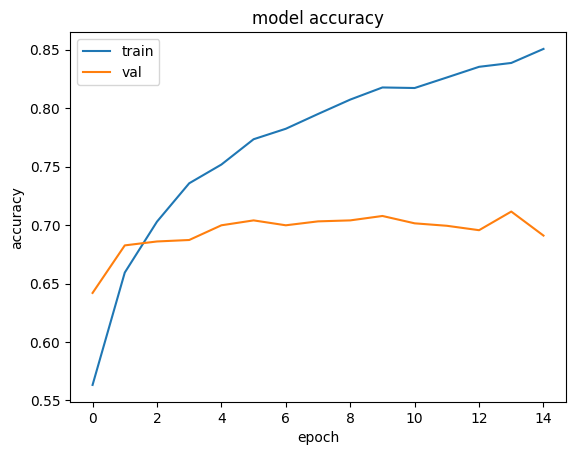

In [ ]:
# Plot the train- and validation-accuracy of last training
plt.plot(base_train_history.history['categorical_accuracy'])
plt.plot(base_train_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

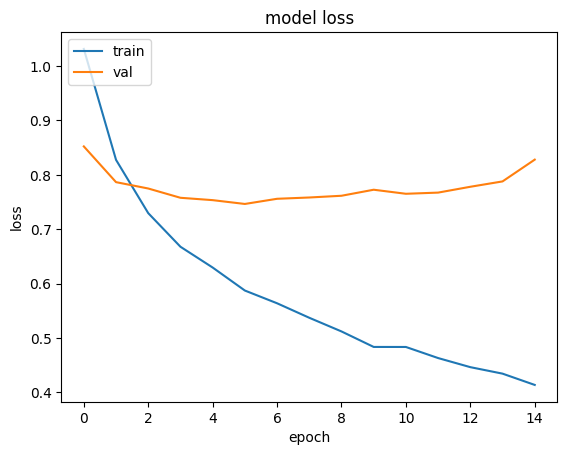

In [ ]:
# Plot the train- and validation-loss of last training
plt.plot(base_train_history.history['loss'])
plt.plot(base_train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# evaluate training with test dataset
loss_test, acc_test = base_model_classifier.evaluate(test_dataset, verbose=2)

94/94 - 11s - loss: 0.8228 - categorical_accuracy: 0.7000 - 11s/epoch - 122ms/step


#### Save model

In [ ]:
## save model 
# base_model_classifier.save(model_folder + "BASE_70_affAHNS_retrain0_lr0005_es7.h5")


In [ ]:
## Load a saved model
base_model_classifier = tf.keras.models.load_model(model_folder + "BASE_70_affAHNS_retrain0_lr0005_es7.h5")

---
### Fine-Tuning


In [ ]:
## ML-Model Constants
LEARNING_RATE = 0.0005 # default = 0.001
TRAIN_EPOCHS = 15
PATIENCE = 7

#### FineTune-Model Definition

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Get base model from Keras api
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
)

In [ ]:
# Print summary of the pretrained model
print(base_model.summary())

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [ ]:
# Freezing Layers
#for layer in base_model.layers[:-76]:
for layer in base_model.layers[:-104]:
    layer.trainable=False

In [ ]:
# Building model to add to base_model
fine_model=Sequential()


fine_model.add(base_model)
fine_model.add(Dropout(0.5))
fine_model.add(Flatten())
fine_model.add(BatchNormalization())
fine_model.add(Dense(256, kernel_initializer='he_uniform'))
fine_model.add(BatchNormalization())
fine_model.add(Activation('relu'))
fine_model.add(Dropout(0.5))
fine_model.add(Dense(64, kernel_initializer='he_uniform'))
fine_model.add(BatchNormalization())
fine_model.add(Activation('relu'))
fine_model.add(Dropout(0.5))
fine_model.add(Dense(32, kernel_initializer='he_uniform'))
fine_model.add(BatchNormalization())
fine_model.add(Activation('relu'))
fine_model.add(Dense(NUM_CLASSES,activation='softmax'))

In [ ]:
# Defining metrics for training
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')]

# Defining callbacks for early stopping
EARLY_STOPPING = EarlyStopping(verbose=1, patience=PATIENCE, restore_best_weights=True, monitor="val_categorical_accuracy")

# Define learningrate for optimizer
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) 

In [ ]:
# Compile the model 
fine_model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
## Print summary of the model
print(fine_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 batch_normalization (BatchN  (None, 62720)            250880    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

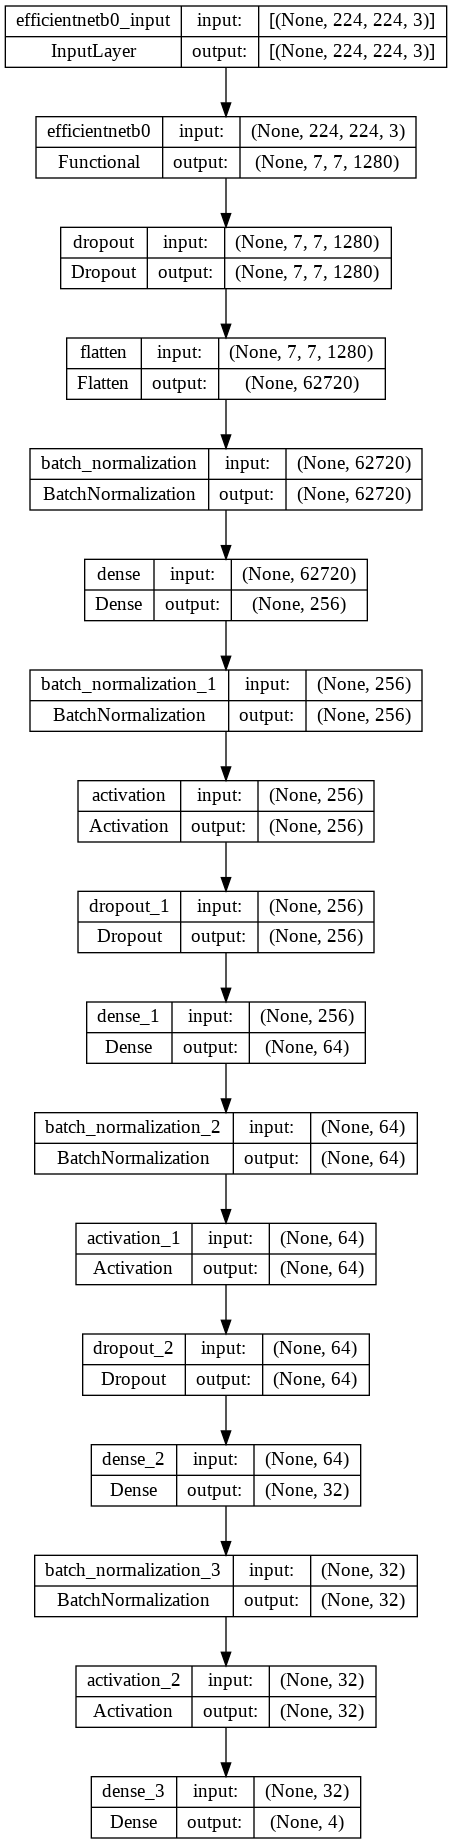

In [ ]:
## Generate a image of the structure of the model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(fine_model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

#### FineTune-Model Training

In [ ]:
# train model
train_history = fine_model.fit(train_dataset_augmented_concat, validation_data=valid_dataset, epochs=TRAIN_EPOCHS, verbose=1, callbacks=[EARLY_STOPPING])

Epoch 1/15
598/598 [==============================] - 70s 109ms/step - loss: 0.4396 - categorical_accuracy: 0.8847 - val_loss: 0.6365 - val_categorical_accuracy: 0.8134
Epoch 2/15
598/598 [==============================] - 64s 106ms/step - loss: 0.2231 - categorical_accuracy: 0.9369 - val_loss: 0.5800 - val_categorical_accuracy: 0.8226
Epoch 3/15
598/598 [==============================] - 64s 106ms/step - loss: 0.1857 - categorical_accuracy: 0.9445 - val_loss: 0.7333 - val_categorical_accuracy: 0.8008
Epoch 4/15
598/598 [==============================] - 65s 109ms/step - loss: 0.1646 - categorical_accuracy: 0.9517 - val_loss: 0.7252 - val_categorical_accuracy: 0.8042
Epoch 5/15
598/598 [==============================] - 64s 106ms/step - loss: 0.1390 - categorical_accuracy: 0.9578 - val_loss: 0.6833 - val_categorical_accuracy: 0.8159
Epoch 6/15
598/598 [==============================] - 64s 106ms/step - loss: 0.1202 - categorical_accuracy: 0.9640 - val_loss: 0.7640 - val_categorical_acc

**Results (1. Epoche):**
Results of various test for hyperparameters and unfreezing!
```
EfficientNetB0-Retrain=0: 
- affect_net(AHNS), train_dataset, EfficientNetB0-Retrain=0, learning_rate=0.0001:
    - 299/299 [==============================] - 102s 323ms/step - loss: 1.2411 - categorical_accuracy: 0.4644 - val_loss: 0.9989 - val_categorical_accuracy: 0.5958
- affect_net(AHNS), train_dataset_augmented, EfficientNetB0-Retrain=0, learning_rate=0.0001:
    - 299/299 [==============================] - 179s 593ms/step - loss: 1.0738 - categorical_accuracy: 0.5483 - val_loss: 0.9336 - val_categorical_accuracy: 0.6294
- affect_net(AHNS), train_dataset_augmented_concat, EfficientNetB0-Retrain=0, learning_rate=0.0001:
    - 598/598 [==============================] - 629s 1s/step - loss: 0.9592 - categorical_accuracy: 0.6033 - val_loss: 0.8582 - val_categorical_accuracy: 0.6637


EfficientNetB0-Retrain=-5:
- affect_net(AHNS), train_dataset, EfficientNetB0-Retrain=-5, learning_rate=0.0001:
    - 299/299 [==============================] - 137s 440ms/step - loss: 1.2833 - categorical_accuracy: 0.4548 - val_loss: 1.0154 - val_categorical_accuracy: 0.5983
- affect_net(AHNS), train_dataset_augmented, EfficientNetB0-Retrain=-5, learning_rate=0.0001:
    - 299/299 [==============================] - 165s 548ms/step - loss: 1.0715 - categorical_accuracy: 0.5464 - val_loss: 0.9584 - val_categorical_accuracy: 0.6029
- affect_net(AHNS), train_dataset_augmented_concat, EfficientNetB0-Retrain=-5, learning_rate=0.0001:
    - 598/598 [==============================] - 351s 578ms/step - loss: 1.2941 - categorical_accuracy: 0.4383 - val_loss: 0.9781 - val_categorical_accuracy: 0.6197


EfficientNetB0-Retrain=-61:
- affect_net(AHNS), train_dataset, EfficientNetB0-Retrain=-61, learning_rate=0.0001:
    - 299/299 [==============================] - 168s 560ms/step - loss: 0.9523 - categorical_accuracy: 0.6122 - val_loss: 0.7561 - val_categorical_accuracy: 0.7065
- affect_net(AHNS), train_dataset_augmented, EfficientNetB0-Retrain=-61, learning_rate=0.0001:
    - 299/299 [==============================] - 168s 554ms/step - loss: 0.8521 - categorical_accuracy: 0.6637 - val_loss: 0.7043 - val_categorical_accuracy: 0.7216
- affect_net(AHNS), train_dataset_augmented_concat, EfficientNetB0-Retrain=-61, learning_rate=0.0001:
    - 598/598 [==============================] - 173s 287ms/step - loss: 0.7085 - categorical_accuracy: 0.7314 - val_loss: 0.6284 - val_categorical_accuracy: 0.7518


learning_rate=0.0005:
- affect_net(AHNS), train_dataset, EfficientNetB0-Retrain=-61, learning_rate=0.0005:
    - 299/299 [==============================] - 40s 108ms/step - loss: 1.0199 - categorical_accuracy: 0.5646 - val_loss: 0.7106 - val_categorical_accuracy: 0.7304
- affect_net(AHNS), train_dataset_augmented, EfficientNetB0-Retrain=-61, learning_rate=0.0005:
    - 299/299 [==============================] - 45s 131ms/step - loss: 0.7204 - categorical_accuracy: 0.7374 - val_loss: 0.6749 - val_categorical_accuracy: 0.7556
- affect_net(AHNS), train_dataset_augmented_concat, EfficientNetB0-Retrain=-61, learning_rate=0.0005:
    - 598/598 [==============================] - 73s 113ms/step - loss: 0.5910 - categorical_accuracy: 0.7965 - val_loss: 0.5991 - val_categorical_accuracy: 0.7820

learning_rate=0.001:
- affect_net(AHNS), train_dataset, EfficientNetB0-Retrain=-61, learning_rate=0.001:
    - 299/299 [==============================] - 94s 297ms/step - loss: 0.9832 - categorical_accuracy: 0.5901 - val_loss: 0.6620 - val_categorical_accuracy: 0.7438
- affect_net(AHNS), train_dataset_augmented, EfficientNetB0-Retrain=-61, learning_rate=0.001:
    - 299/299 [==============================] - 173s 572ms/step - loss: 0.7029 - categorical_accuracy: 0.7333 - val_loss: 0.6457 - val_categorical_accuracy: 0.7568
- affect_net(AHNS), train_dataset_augmented_concat, EfficientNetB0-Retrain=-61, learning_rate=0.001:
    - 598/598 [==============================] - 1400s 2s/step - loss: 0.5652 - categorical_accuracy: 0.7893 - val_loss: 0.6146 - val_categorical_accuracy: 0.7803


EfficientNetB0-Retrain=-76:
- affect_net(AHNS), train_dataset_augmented_concat, EfficientNetB0-Retrain=-76, learning_rate=0.0005:
    Epoch 1/8
    598/598 [==============================] - 211s 344ms/step - loss: 0.8448 - categorical_accuracy: 0.6507 - val_loss: 0.5615 - val_categorical_accuracy: 0.7912
    Epoch 2/8
    598/598 [==============================] - 99s 165ms/step - loss: 0.5277 - categorical_accuracy: 0.8058 - val_loss: 0.4868 - val_categorical_accuracy: 0.8151
    Epoch 3/8
    598/598 [==============================] - 97s 162ms/step - loss: 0.4071 - categorical_accuracy: 0.8512 - val_loss: 0.5343 - val_categorical_accuracy: 0.8101
    Epoch 4/8
    598/598 [==============================] - 85s 141ms/step - loss: 0.3009 - categorical_accuracy: 0.8970 - val_loss: 0.5622 - val_categorical_accuracy: 0.8172
    Epoch 5/8
    598/598 [==============================] - 87s 145ms/step - loss: 0.2517 - categorical_accuracy: 0.9135 - val_loss: 0.5850 - val_categorical_accuracy: 0.8075
    Epoch 6/8
    598/598 [==============================] - 79s 132ms/step - loss: 0.2007 - categorical_accuracy: 0.9352 - val_loss: 0.7140 - val_categorical_accuracy: 0.7929
    Epoch 7/8
    598/598 [==============================] - 91s 153ms/step - loss: 0.1737 - categorical_accuracy: 0.9431 - val_loss: 0.7241 - val_categorical_accuracy: 0.7954
    Epoch 8/8
    598/598 [==============================] - 77s 128ms/step - loss: 0.1490 - categorical_accuracy: 0.9513 - val_loss: 0.7408 - val_categorical_accuracy: 0.8038

EfficientNetB0-Retrain=-91:
- affect_net(AHNS), train_dataset_augmented_concat, EfficientNetB0-Retrain=-91, learning_rate=0.0005:
    Output exceeds the size limit. Open the full output data in a text editor
    Epoch 1/15
    598/598 [==============================] - 71s 103ms/step - loss: 0.8329 - categorical_accuracy: 0.6609 - val_loss: 0.5869 - val_categorical_accuracy: 0.7761
    Epoch 2/15
    598/598 [==============================] - 60s 100ms/step - loss: 0.5114 - categorical_accuracy: 0.8133 - val_loss: 0.4585 - val_categorical_accuracy: 0.8327
    Epoch 3/15
    598/598 [==============================] - 60s 100ms/step - loss: 0.3840 - categorical_accuracy: 0.8661 - val_loss: 0.4844 - val_categorical_accuracy: 0.8277
    Epoch 4/15
    598/598 [==============================] - 60s 100ms/step - loss: 0.2942 - categorical_accuracy: 0.9001 - val_loss: 0.5688 - val_categorical_accuracy: 0.8084
    Epoch 5/15
    598/598 [==============================] - 60s 100ms/step - loss: 0.2344 - categorical_accuracy: 0.9212 - val_loss: 0.5606 - val_categorical_accuracy: 0.8130
    Epoch 6/15
    598/598 [==============================] - 60s 100ms/step - loss: 0.1878 - categorical_accuracy: 0.9386 - val_loss: 0.6160 - val_categorical_accuracy: 0.8235
    Epoch 7/15
    598/598 [==============================] - 61s 102ms/step - loss: 0.1696 - categorical_accuracy: 0.9450 - val_loss: 0.6213 - val_categorical_accuracy: 0.8252
    Epoch 8/15
    598/598 [==============================] - 60s 100ms/step - loss: 0.1539 - categorical_accuracy: 0.9494 - val_loss: 0.5868 - val_categorical_accuracy: 0.8390
    Epoch 9/15
    598/598 [==============================] - 60s 100ms/step - loss: 0.1266 - categorical_accuracy: 0.9601 - val_loss: 0.6409 - val_categorical_accuracy: 0.8298
    Epoch 10/15
    598/598 [==============================] - 60s 100ms/step - loss: 0.1147 - categorical_accuracy: 0.9625 - val_loss: 0.7411 - val_categorical_accuracy: 0.8197
    Epoch 11/15
    598/598 [==============================] - 60s 100ms/step - loss: 0.1042 - categorical_accuracy: 0.9678 - val_loss: 0.6427 - val_categorical_accuracy: 0.8386
    Epoch 12/15
    598/598 [==============================] - 60s 100ms/step - loss: 0.0862 - categorical_accuracy: 0.9732 - val_loss: 0.7274 - val_categorical_accuracy: 0.8289
    Epoch 13/15
    ...
    Epoch 15/15
    597/598 [============================>.] - ETA: 0s - loss: 0.0858 - categorical_accuracy: 0.9735Restoring model weights from the end of the best epoch: 8.
    598/598 [==============================] - 60s 100ms/step - loss: 0.0858 - categorical_accuracy: 0.9735 - val_loss: 0.7710 - val_categorical_accuracy: 0.8193
    Epoch 15: early stopping

EfficientNetB0-Retrain=-104:
- affect_net(AHNS), train_dataset_augmented_concat, EfficientNetB0-Retrain=-104, learning_rate=0.0005:
    Epoch 1/15
    598/598 [==============================] - 70s 108ms/step - loss: 0.8042 - categorical_accuracy: 0.6799 - val_loss: 0.5259 - val_categorical_accuracy: 0.7899
    Epoch 2/15
    598/598 [==============================] - 63s 105ms/step - loss: 0.5000 - categorical_accuracy: 0.8219 - val_loss: 0.4824 - val_categorical_accuracy: 0.8222
    Epoch 3/15
    598/598 [==============================] - 63s 105ms/step - loss: 0.3654 - categorical_accuracy: 0.8712 - val_loss: 0.5288 - val_categorical_accuracy: 0.8130
    Epoch 4/15
    598/598 [==============================] - 63s 105ms/step - loss: 0.2952 - categorical_accuracy: 0.8988 - val_loss: 0.4686 - val_categorical_accuracy: 0.8369
    Epoch 5/15
    598/598 [==============================] - 63s 105ms/step - loss: 0.2320 - categorical_accuracy: 0.9222 - val_loss: 0.5502 - val_categorical_accuracy: 0.8302
    Epoch 6/15
    598/598 [==============================] - 63s 105ms/step - loss: 0.2021 - categorical_accuracy: 0.9340 - val_loss: 0.5946 - val_categorical_accuracy: 0.8289
    Epoch 7/15
    598/598 [==============================] - 63s 105ms/step - loss: 0.1763 - categorical_accuracy: 0.9436 - val_loss: 0.6082 - val_categorical_accuracy: 0.8176
    Epoch 8/15
    598/598 [==============================] - 63s 105ms/step - loss: 0.1428 - categorical_accuracy: 0.9560 - val_loss: 0.6586 - val_categorical_accuracy: 0.8122
    Epoch 9/15
    598/598 [==============================] - 63s 105ms/step - loss: 0.1330 - categorical_accuracy: 0.9583 - val_loss: 0.6423 - val_categorical_accuracy: 0.8319
    Epoch 10/15
    598/598 [==============================] - 63s 105ms/step - loss: 0.1141 - categorical_accuracy: 0.9633 - val_loss: 0.6430 - val_categorical_accuracy: 0.8331
    Epoch 11/15
    598/598 [==============================] - 63s 105ms/step - loss: 0.1055 - categorical_accuracy: 0.9667 - val_loss: 0.6348 - val_categorical_accuracy: 0.8373
    Epoch 12/15
    598/598 [==============================] - 63s 105ms/step - loss: 0.0957 - categorical_accuracy: 0.9693 - val_loss: 0.7768 - val_categorical_accuracy: 0.8218
    Epoch 13/15
    ...
    Epoch 14/15
    598/598 [==============================] - 64s 107ms/step - loss: 0.0841 - categorical_accuracy: 0.9734 - val_loss: 0.7251 - val_categorical_accuracy: 0.8252
    Epoch 15/15
    598/598 [==============================] - 64s 106ms/step - loss: 0.0776 - categorical_accuracy: 0.9754 - val_loss: 0.7069 - val_categorical_accuracy: 0.8340
    
    --> 83_affAHNS_retrain104_lr0005_es3.h5
```

#### FineTune-Model Evaluation

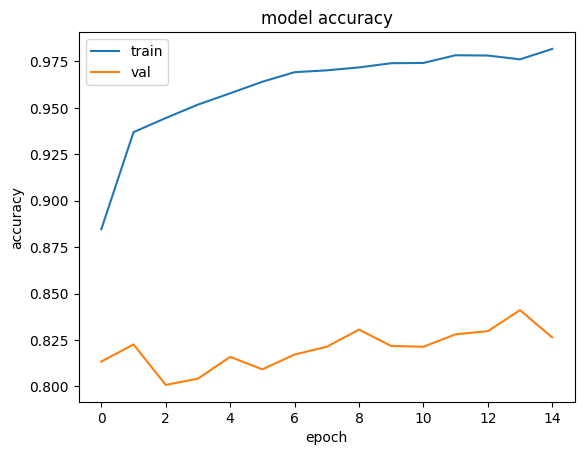

In [ ]:
# Plot the train- and validation-accuracy of last training
plt.plot(train_history.history['categorical_accuracy'])
plt.plot(train_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

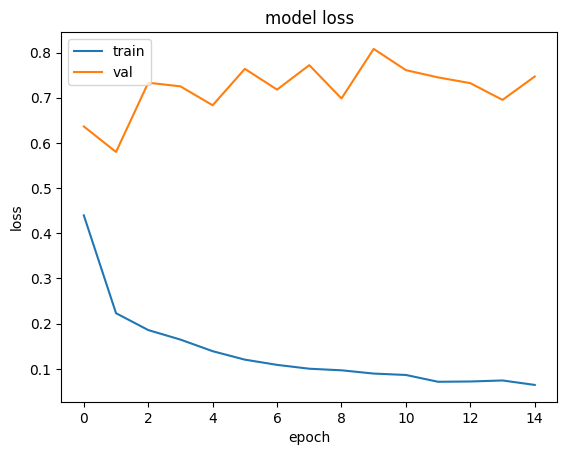

In [ ]:
# Plot the train- and validation-loss of last training
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# evaluate training with test dataset
loss_test, acc_test = fine_model.evaluate(test_dataset, verbose=2)

94/94 - 5s - loss: 0.7836 - categorical_accuracy: 0.8136 - 5s/epoch - 53ms/step


#### Save Model

In [ ]:
## save model 
# fine_model.save(model_folder + "NEW_83_affAHNS_retrain104_lr0005_es3.h5")

In [ ]:
## Load a saved model
fine_model = tf.keras.models.load_model(model_folder + "83_affAHNS_retrain104_lr0005_es3.h5")

---
## Demo - Eigene Bilder Klassifizieren



### 1. Bild Generieren (GColab Only)

In [ ]:
# define the image to be categorized (image.jpg = without crop)
# demo_image = "image_crop.jpg"
demo_image = "image.jpg"
## GDrive demo-image folder
# demo_image_path = root_directory + "demo/"

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


# get webcam access and make a photo for classification demo
def take_photo(filename='image.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from PIL import Image
 
im = Image.open("image.jpg")
 
width, height = im.size
print(width, height)
 
# left, upper combo gives the upper left corner coordinates
# right, lower combo gives the lower right corner coordinates
def crop_image(im: Image, left, upper, right, lower):
   im2 = im.crop((left, upper, right, lower))
   im2.show()
   return im2


def resize_image(im:Image, width, height):
   im1 = im.resize((width, height))
   im1.show()
   return im1

def save_image(im:Image, filename):
   im.save(filename)

## Set the pixels of the croped Image
cropped = crop_image(im, 80, 0, 560, 480)
save_image(cropped, "image_crop.jpg")

640 480


### 2. Bild Wählen

In [ ]:
demo_image_path = root_directory + "demo/"
## Raw webcam image
demo_image = "image.jpg"

## Croped webcam image
demo_image = "image_crop.jpg"

## Custom test images:
#demo_image = demo_image_path + "imageHappy.jpg"
#demo_image = demo_image_path + "imageSad.jpg"


In [ ]:
# read demo image file
tf_image = tf.keras.utils.load_img(demo_image, target_size=(IMG_HEIGHT, IMG_WIDTH))
input_arr = tf.keras.preprocessing.image.img_to_array(tf_image)

In [ ]:
# display image
tf_image

### 3. Bild Klassifizieren

In [ ]:
## Model wählen:
# MODEL = baseLine_model
#MODEL = base_model_classifier
MODEL = fine_model

In [ ]:
# convert image to np.array
input_batch = np.array([input_arr])

# predict classification of the image
prediction = MODEL.predict(input_batch)

1/1 [==============================] - 0s 25ms/step


In [ ]:
print("Predicted Class: ", CLASSES[np.argmax(prediction)])

Predicted Class:  ANGER


### 4. Metriken Auswerten

In [ ]:
# get all prediction values
pred = []
for i,value in enumerate(prediction[0]):
    if i == np.argmax(prediction):
        print(CLASSES[i], ": ", value, "<--- Predicted Mood")
        pred.append(value)
    else:
         print(CLASSES[i], ": ", value)
         pred.append(value)

ANGER :  0.9953057 <--- Predicted Mood
HAPPY :  0.00033384998
NEUTRAL :  0.0006059106
SAD :  0.0037544717


<BarContainer object of 4 artists>

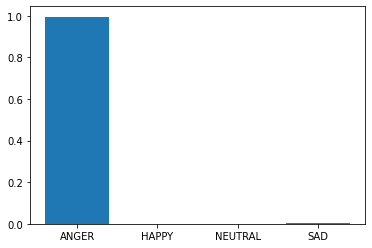

In [ ]:
# plot predicted values
plt.bar(CLASSES, pred)
